<a target="_blank" href="https://colab.research.google.com/github/markusmeister/MIB-Public/blob/master/Figures_Ch_13.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Ch 13 - Applications of Nonlinear Dynamics

This notebook contains python code for generating figures in Chapter 13 of the book _Mathematics in Biology_.

## Imports and utilities

In [1]:
import numpy as np
from pathlib import Path
import matplotlib
from matplotlib import pyplot as plt
from matplotlib.markers import MarkerStyle
import matplotlib.gridspec as gridspec


# set font to be used in figures
import matplotlib.font_manager as font_manager
matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['font.family'] = 'serif'
cmfont = font_manager.FontProperties(fname=matplotlib.get_data_path() + '/fonts/ttf/cmr10.ttf')
matplotlib.rcParams['font.serif']=cmfont.get_name()
matplotlib.rcParams['axes.formatter.use_mathtext'] = True
matplotlib.rcParams['axes.unicode_minus']=False
matplotlib.rcParams['font.size'] = 11

datadir = Path('../data') # need to find a way to load data for execution in Colab!


Save = False # set to True if you are saving figures to a local drive
if Save:
    # set path to save the figures
    savedir = Path('../img')
    savedir.mkdir(parents=True, exist_ok=True)

In [2]:
# Utilities for plotting

def plot(X, Y=None, xlabel=None, ylabel=None, legend=[], loc=None, title=None, alpha=1.0,
         xlim=None, ylim=None, xscale='linear', yscale='linear',
         xticks=None, yticks=None, xhide=False, yhide=False, yrot=False,
         xzero=False, yzero=False, yflip=False,
         fmts=['r-','g-','b-','y-','c-','m-'], linewidth=2, markersize=5, fillstyle='full',
         markeredgewidth=1, rasterized=False,
         grid=False, equal=False, figsize=(5,3), axes=None):
    """
    Plot data points.
    X: an array or list of arrays
    Y: an array or list of arrays
    If Y exists then those values are plotted vs the X values
    If Y doesn't exist the X values are plotted
    xlabel, ylabel: axis labels
    legend: list of labels for each Y series
    loc: location of the legend, like 'upper right'
    title: duh
    xlim, ylim: [low,high] list of limits for the 2 axes
    xscale, yscale: 'linear' or 'log'
    xticks, yticks: list of locations for tick marks, or None for auto ticks
    yhide: hide the y axis?
    yrot: rotate the yaxis label to horizontal?
    yzero: zero line for the y-axis?
    fmts: a list of format strings to be applied to successive Y-series
    linewidth, markersize, fillstyle, markeredgewidth: see docs
    grid: draw a grid?
    equal: use equal aspect ratio, i.e. same scale per unit on x and y axis?
    figsize: (h,v) in inches
    rasterized: rasterize the data portion of the graph?
    axes: pre-existing axes where to draw the plot
    Returns: axes for the plot
    """

    if not axes: # start a new figure
        fig = plt.figure(figsize=figsize)
        axes = plt.gca()

    def has_one_axis(X): # Return True if X (ndarray or list) has 1 axis
        return (hasattr(X, "ndim") and X.ndim == 1 or isinstance(X, list)
                and not hasattr(X[0], "__len__"))

    if has_one_axis(X):
        X = [X]
    if Y is None:
        X, Y = [[]] * len(X), X
    elif has_one_axis(Y):
        Y = [Y]
    if len(X) != len(Y):
        X = X * len(Y)
    # axes.cla() # clears these axes
    for x, y, fmt in zip(X, Y, fmts):
        if len(x):
            axes.plot(x, y, fmt, linewidth=linewidth, markersize=markersize,
            	fillstyle=fillstyle,markeredgewidth=markeredgewidth,
            	rasterized=rasterized, alpha=alpha)
        else:
            axes.plot(y, fmt, linewidth=linewidth, markersize=markersize,
            	fillstyle=fillstyle,markeredgewidth=markeredgewidth,
            	rasterized=rasterized, alpha=alpha)
    set_axes(axes, xlabel, ylabel, legend, loc, xlim, ylim, xscale, yscale,
             xticks, yticks, xhide, yhide, yrot, xzero, yzero, yflip, grid, equal)
    if title:
        plt.title(title)
    plt.tight_layout()

    return axes # useful if we started a new figure

def hist(X, bins=50, range=None, density=None, weights=None, histtype='stepfilled', stacked=False,
         align='mid', color=['r','g','b','m'], alpha=0.5, linewidth=1,
         xlabel=None, ylabel=None, legend=[], loc=None, title=None,
         xlim=None, ylim=None, xscale='linear', yscale='linear',
         xticks=None, yticks=None, xhide=False, yhide=False, yrot=False,
         xzero=False, yzero=False, yflip=False,
         grid=False, figsize=(5,3), axes=None, orientation='vertical'):
    """
    Histogram data.
    X: an array or list of arrays to be histogrammed
    bins: the number of bins, or a list of edges
    range: [low,high] the range over which the bins are spread
    density: normalize to unit area?
    weights: array same shape as X; each value in X only contributes that weight.
    histtype: 'bar','barstacked','step','stepfilled'
    stacked: plot multiple series on top of each other?
    align: 'left','mid',right', center the bar on left edge, center, or right edge of bin
    color: list of colors for the data series
    alpha: opacity, useful if histtype='stepfilled'
    xlabel, ylabel: axis labels
    legend: list of labels for each Y series
    loc: location of the legend, like 'upper right'
    title: duh
    xlim, ylim: [low,high] list of limits for the 2 axes
    xscale, yscale: 'linear' or 'log'
    xticks, yticks: list of locations for tick marks, or None for auto ticks
    yhide: hide the y axis?
    yrot: rotate the yaxis label to horizontal?
    yzero: zero line for the y-axis?
    grid: draw a grid?
    figsize: (h,v) in inches
    axes: pre-existing axes where to draw the plot
    Returns: axes, n, bins, patches
    """

    if not axes: # start a new figure
        fig,ax = plt.subplots(figsize=figsize)
    else:
    	ax=axes

    def has_one_axis(X): # Return True if X (ndarray or list) has 1 axis
        return (hasattr(X, "ndim") and X.ndim == 1 or isinstance(X, list) and not hasattr(X[0], "__len__"))

    if has_one_axis(X):
        ndata=1
    else:
        ndata=len(X) # assuming it is an ndarray or a list of lists

    if len(color)<ndata: # if there aren't enough dolors provided
        col=None # use the default color sequence
    else:
        col=color[:ndata]

    if histtype=='step' or histtype=='stepfilled': # in these cases the legend sequence needs to be inverted for some reason
        if isinstance(legend, list):
        	legend = legend[-1::-1]

    n, bins, patches = ax.hist(X, bins=bins, range=range, density=density, weights=weights,
                               histtype=histtype, stacked=stacked, align=align,
                               color=col, alpha=alpha, linewidth=linewidth,
                               label=legend, orientation=orientation)

    set_axes(ax, xlabel, ylabel, legend, loc, xlim, ylim, xscale, yscale,
    	xticks, yticks, xhide, yhide, yrot, xzero, yzero, yflip, grid, equal=False)

    if title:
        plt.title(title)
    if not axes:
    	plt.tight_layout() # otherwise let the caller take care of layout

    return ax, n, bins, patches # useful if we started a new figure

def set_axes(axes, xlabel, ylabel, legend, loc, xlim, ylim, xscale, yscale,
    	xticks, yticks, xhide, yhide, yrot, xzero, yzero, yflip, grid, equal):
    """Set the axes for matplotlib."""
    axes.set_xscale(xscale)
    axes.set_yscale(yscale)
    if xlim:
        axes.set_xlim(xlim)
    else:
        axes.set_xlim(auto=True)
    if ylim:
        axes.set_ylim(ylim)
    else:
        axes.set_ylim(auto=True)
    if grid:
        axes.grid()
    if equal:
        axes.set_aspect(aspect='equal')
    if ylabel:
        if yrot:
            axes.set_ylabel(ylabel, fontsize=12, rotation=0, labelpad=15)
        else:
            axes.set_ylabel(ylabel, fontsize=12)
    if xlabel:
        axes.set_xlabel(xlabel, fontsize=12)
    axes.get_yaxis().set_visible(not yhide)
    axes.get_xaxis().set_visible(not xhide)
    if xzero:
        axes.axvline(color='black', linewidth=0.5)
    if yzero:
        axes.axhline(color='black', linewidth=0.5)
    if yflip:
        axes.invert_yaxis()
    axes.tick_params(axis = 'both', which = 'major', labelsize = 10)
    axes.tick_params(axis = 'both', which = 'minor', labelsize = 9)
    if xticks != None:
        axes.set_xticks(xticks); # no minor ticks
    if yticks != None:
        axes.set_yticks(yticks); # no minor ticks
    if legend:
        axes.legend(legend, loc=loc)
    plt.draw()
    #     To change the font and control the fontsize, can use some of these commands:
    #     axes.set_xlabel(xlabel, fontname='Arial', fontsize = 12)
    #     axes.set_ylabel(ylabel, fontname='Arial', fontsize = 12)
    #     axes.tick_params(axis = 'both', which = 'major', labelsize = 10)
    #     axes.tick_params(axis = 'both', which = 'minor', labelsize = 9)
    #     plt.yticks(fontname = "Arial")
    #     plt.xticks(fontname = "Arial")
    #     if legend:
    #         axes.legend(legend, prop={"size":12, "family":'Arial'})
    #     For options on legend placement see https://stackoverflow.com/questions/4700614/how-to-put-the-legend-out-of-the-plot

def test_plot():
    x = np.arange(-10,10,.01)
    t = [0.1,0.3,1,3,10]
    y = [np.exp(-x**2/(4*ti))/np.sqrt(4*np.pi*ti) for ti in t]
    plot (x,y,fmts=['r-','g-','b-','y-','c-','m-'],linewidth=1,
        xlabel='Distance',ylabel='Concentration',yzero=True,
        legend=['t=0.1','0.3','1','3','10'],xticks=[-10,-5,-1,0,1,5,10])

## Repressilator

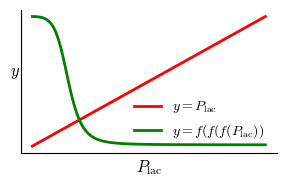

In [3]:
def f(x,alpha=10,alpha_0=5e-4,n=2.0):
    return alpha/(1+x**n)+alpha_0

x = np.arange(0,10,0.1)
y1 = x
y2 = f(f(f(x)))

fig, ax = plt.subplots(figsize=(3,2))
legend = ['$y=P_{\mathrm{lac}}$', '$y=f(f(f(P_{\mathrm{lac}}))$']
plot(x,[y1,y2], xlabel="$P_{\mathrm{lac}}$", axes=ax)
# ax.text(7.5, 1, '$\\alpha=10$', fontsize=11)
ax.legend(legend,frameon=False,loc='lower right', fontsize=10)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylabel('$y$', rotation=0, fontdict={'fontsize':12})
ax.set_yticks([])
ax.set_xticks([])
fig.tight_layout();
if Save:
    fig.savefig(str(savedir / 'repressilator-fp.pdf'), bbox_inches='tight');
    fig.savefig(str(savedir / 'repressilator-fp.svg'), bbox_inches='tight');

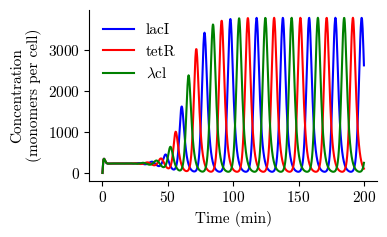

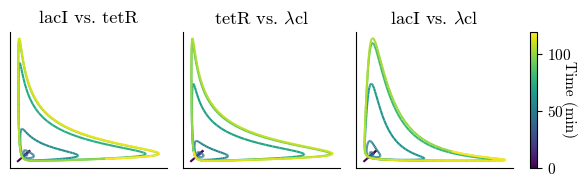

In [4]:
from scipy.integrate import odeint

# model for the dynamical system
def model(x,t):
    """
    Repressilator model.
    index:
        0: lacI
        1: tetR
        2: cl
    """
    # parameters
    alpha = 200
    alpha0 = 5e-4
    beta = 4.0
    n = 2.0
    # unpack
    m0, m1, m2, p0, p1, p2 = x
    # diff eqs
    m0_dot = -m0 + alpha / (1.0 + p2**n) + alpha0
    m1_dot = -m1 + alpha / (1.0 + p0**n) + alpha0
    m2_dot = -m2 + alpha / (1.0 + p1**n) + alpha0
    p0_dot = -beta*(p0-m0)
    p1_dot = -beta*(p1-m1)
    p2_dot = -beta*(p2-m2)
    return [m0_dot,m1_dot,m2_dot,p0_dot,p1_dot,p2_dot]

# initial conditions
x0 = [0.01,0.02,0.03,0.0,0.0,0.0]

# time points
t = np.linspace(0,100,1000)

# solve!
x = odeint(model,x0,t)

# dimensional (re)scaling
mRNA_half_life = 2 # minutes
K_M = 40 # monomers per cell
x = x*K_M
t = t*mRNA_half_life

fig, ax = plt.subplots(figsize=(4,2.5))
ax.plot(t,x[:,3],'b-',label='lacI')
ax.plot(t,x[:,4],'r-',label='tetR')
ax.plot(t,x[:,5],'g-',label='$\lambda$cl')
ax.set_ylabel('Concentration\n(monomers per cell)')
ax.set_xlabel('Time (min)')
ax.legend(loc='best', frameon=False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
fig.tight_layout()
if Save:
    fig.savefig(str(savedir / 'repressilator-time-evolution.pdf'), bbox_inches='tight');
    fig.savefig(str(savedir / 'repressilator-time-evolution.svg'), bbox_inches='tight');

# phase space
fig = plt.figure(figsize=(6,2))
gs = gridspec.GridSpec(1, 4, width_ratios=[1,1,1,0.05])  # Adjust width ratios as needed
ax0 = fig.add_subplot(gs[0])
ax1 = fig.add_subplot(gs[1])
ax2 = fig.add_subplot(gs[2])
ax3 = fig.add_subplot(gs[3])

ax0.set_xticks([])
ax1.set_xticks([])
ax2.set_xticks([])

ax0.set_yticks([])
ax1.set_yticks([])
ax2.set_yticks([])

ax0.spines['top'].set_visible(False)
ax0.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
import matplotlib.colors as mcolors

def create_line_collection(t, x, y, cmap = plt.cm.viridis):
    # Create line segments
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    # Create a colormap for time data
    n_colors = len(x)  # Increase this number as needed
    new_colors = cmap(np.linspace(0, 1, n_colors))
    interpolated_cmap = mcolors.LinearSegmentedColormap.from_list("interpolated_cmap", new_colors, N=n_colors)
    # norm = BoundaryNorm(np.linspace(0, 1, N), cmap.N)

    # Create a LineCollection
    lc = LineCollection(segments, cmap=interpolated_cmap)
    lc.set_array(t)
    return lc

t_end_idx = 600
lc = create_line_collection(t[:t_end_idx], x[:t_end_idx,3], x[:t_end_idx,4])
ax0.add_collection(lc)
lc = create_line_collection(t[:t_end_idx], x[:t_end_idx,4], x[:t_end_idx,5])
ax1.add_collection(lc)
lc = create_line_collection(t[:t_end_idx], x[:t_end_idx,3], x[:t_end_idx,5])
ax2.add_collection(lc)

ax0.autoscale()
ax1.autoscale()
ax2.autoscale()

ax0.set_title("lacI vs. tetR")
ax1.set_title("tetR vs. $\lambda$cl")
ax2.set_title("lacI vs. $\lambda$cl")

# ax0.set_axis_off()
# ax1.set_axis_off()
# ax2.set_axis_off()

# Adding a colorbar
cbar = plt.colorbar(lc, cax=ax3)
cbar.set_label('Time (min)', rotation=270)
# cbar.ax.yaxis.set_label_coords(-0.5, 0.5)
fig.tight_layout()
if Save:
    fig.savefig(str(savedir / 'Repressilator-2DTraj.pdf'), bbox_inches='tight');
    fig.savefig(str(savedir / 'Repressilator-2DTraj.svg'), bbox_inches='tight');



## Fold change detection

<ipython-input-5-1aab3da2de92>:36: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  fig.tight_layout()


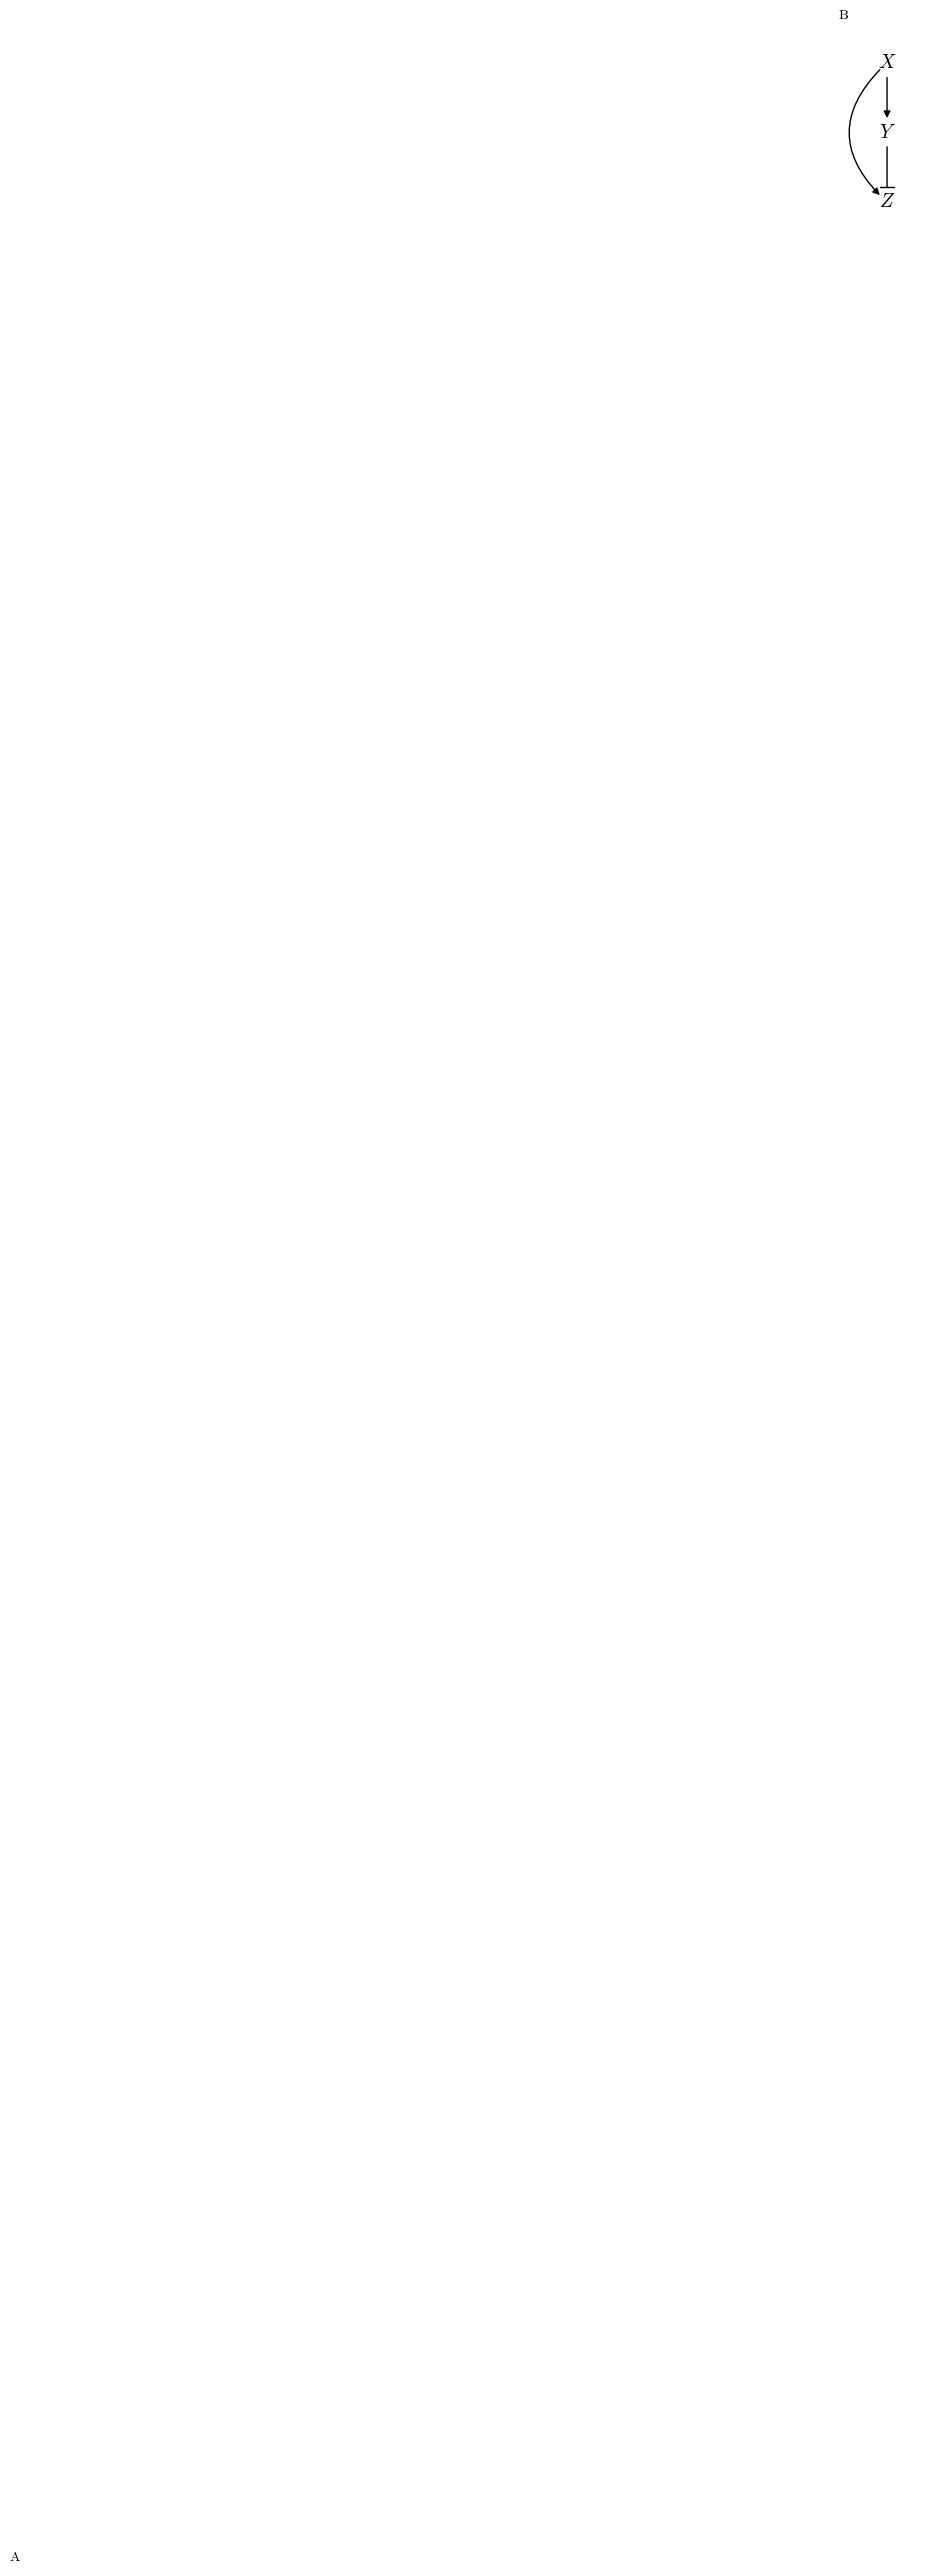

In [5]:
import matplotlib.patches as patches

# fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(5,3)) #, gridspec_kw={'height_ratios': [2,3,4]})
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(5,3), gridspec_kw={'width_ratios': [3, 1]})

# axes[0].set_xlim([-0.5,2*np.pi+0.2])
# axes[0].set_ylim([-1.2,1.2])
ax2.text(0,1.005,r'B',fontsize=10,color='k',ha='center',va='center')
ax2.text(0.5,0.8,r'$X$',fontsize=14,color='k',ha='center',va='center')
ax2.text(0.5,0.5,r'$Y$',fontsize=14,color='k',ha='center',va='center')
ax2.text(0.5,0.2,r'$Z$',fontsize=14,color='k',ha='center',va='center')

ax2.add_patch(patches.FancyArrowPatch(posA=(0.5, 0.75), posB=(0.5, 0.55),
                                          lw=1, arrowstyle=u'-|>',
                                          mutation_scale=10,color='black'))
ax2.add_patch(patches.FancyArrowPatch(posA=(0.5, 0.45), posB=(0.5, 0.25),
                                          lw=1, arrowstyle=u'|-|, widthA=0, widthB=1',
                                          mutation_scale=5,color='black'))
ax2.add_patch(patches.FancyArrowPatch(posA=(0.44, 0.78), posB=(0.44, 0.22), connectionstyle="arc3,rad=0.5",
                                          lw=1, arrowstyle=u'-|>',
                                          mutation_scale=10,color='black'))

ax2.set_axis_off()

import matplotlib.image as mpimg

# ax2 = axes[1].inset_axes([-0.8, -1, 8, 4], transform = axes[2].transData)
# im2 = mpimg.imread(savedir / 'fcd_vec.png')
# ax1.imshow(im2,cmap='gray',aspect='auto')
# ax2.axis('off')
# ax2.axis('off')
# axes[2].set_xlim([-0.5,2*np.pi+0.2])
# ax2.set_ylim([600,-3])
ax1.text(-2,-10,r'A',fontsize=10,color='k',ha='center',va='center')
ax1.set_axis_off()
fig.tight_layout()

if Save:
    fig.savefig(str(savedir / 'fcd_combined.pdf'), bbox_inches='tight');
    fig.savefig(str(savedir / 'fcd_combined.svg'), bbox_inches='tight');

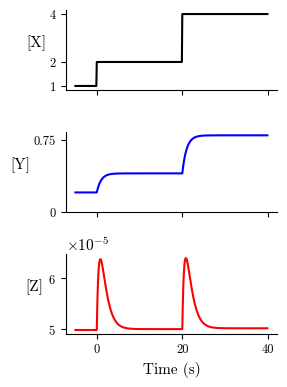

In [6]:
from scipy.integrate import odeint

# model for the dynamical system
def model(x,t):
    """
    FCD
    """
    # parameters
    alpha_1 = 1.0
    alpha_2 = 1.0
    beta_1 = 200.0
    beta_2 = 10.0
    K_XY = 1000
    K_XZ = 1000
    K_YZ = 0.001

    # unpack
    X, Y, Z = x

    # diff eqs
    X_dot = 0
    Y_dot = -alpha_1*Y + beta_1*X/K_XY / (1+X/K_XY)
    Z_dot = -alpha_2*Z + beta_2*X/K_XZ / (1+X/K_XZ+Y/K_YZ)

    return X_dot, Y_dot, Z_dot

# initial conditions
x0 = [1,0,0]

# time points
t1 = np.arange(-20,0,0.1)
t2 = np.arange(0,20,0.1)
t3 = np.arange(20,40,0.1)

# solve
x1 = odeint(model,x0,t1)
x2 = odeint(model,[2,x1[-1][1],x1[-1][2]],t2)
x3 = odeint(model,[4,x2[-1][1],x2[-1][2]],t3)

# visualize
t = np.concatenate((t1,t2,t3),axis=0)
X = np.concatenate((x1,x2,x3),axis=0)[:,0]
Y = np.concatenate((x1,x2,x3),axis=0)[:,1]
Z = np.concatenate((x1,x2,x3),axis=0)[:,2]

fig, ax = plt.subplots(3,1,figsize=(3,4))

ax[0].plot(t[t>-5],X[t>-5],'k-');
ax[1].plot(t[t>-5],Y[t>-5],'b-');
ax[2].plot(t[t>-5],Z[t>-5],'r-');

ax[0].set_ylabel('[X]', rotation=0, labelpad=10)
ax[1].set_ylabel('[Y]', rotation=0, labelpad=10)
ax[2].set_ylabel('[Z]', rotation=0, labelpad=10)
ax[2].set_xlabel('Time (s)')

ax[0].set_yticks([1,2,4])
ax[0].set_yticklabels([1,2,4],fontsize=9)
ax[0].set_xticklabels([])

ax[1].set_yticks([0,0.75])
ax[1].set_yticklabels([0,0.75],fontsize=9)
ax[1].set_xticklabels([])


# ax[0].tick_params(axis='y', labelsize=9)
# ax[1].tick_params(axis='y', labelsize=9)
ax[2].tick_params(axis='y', labelsize=9)
ax[2].set_xticks([0,20,40])
ax[2].set_xticklabels([0,20,40],fontsize=9)

# ax[2].set_yticklabels([0,6e-5],fontsize=9)

ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
ax[2].spines['top'].set_visible(False)
ax[2].spines['right'].set_visible(False)

fig.tight_layout()
if Save:
    fig.savefig(str(savedir / 'foldchange.pdf'), bbox_inches='tight')
    fig.savefig(str(savedir / 'foldchange.svg'), bbox_inches='tight')

## Bistability

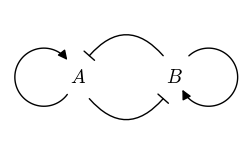

In [7]:
import matplotlib.patches as patches
from matplotlib.path import Path



fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(3,2), )

ax.text(1,1,r'$A$',fontsize=14,color='k',ha='center',va='center')
ax.text(2,1,r'$B$',fontsize=14,color='k',ha='center',va='center')

def generate_circular_path_for_arrow(center, radius, rotation='cw', flip_dir=False, num_points=100, n_omit_points_beginning=10, n_omit_points_end=10):

    # Generate the points along the circle
    theta = np.linspace(0, 2 * np.pi, num_points)
    if rotation == 'cw':
        x = radius * np.cos(theta) + center[0]
    elif rotation == 'ccw':
        x = -radius * np.cos(theta) + center[0]
    y = radius * np.sin(theta) + center[1]
    # Combine the points into a path
    if flip_dir:
        verts = list(zip(x[n_omit_points_beginning:-n_omit_points_end][::-1], y[n_omit_points_beginning:-n_omit_points_end][::-1]))
    else:
        verts = list(zip(x[n_omit_points_beginning:-n_omit_points_end], y[n_omit_points_beginning:-n_omit_points_end]))

    codes = [Path.MOVETO] + [Path.LINETO] * (num_points - 2-n_omit_points_beginning-n_omit_points_end) + [Path.LINETO]
    path = Path(verts, codes)
    return path

path = generate_circular_path_for_arrow(center= (0.65, 1), radius=0.3, flip_dir=True)
ax.add_patch(patches.FancyArrowPatch(path=path,
                                     lw=1, arrowstyle=u'-|>',
                                     mutation_scale=14,color='k'))

path = generate_circular_path_for_arrow(center= (2.35, 1), radius=0.3, rotation='ccw',
                                        n_omit_points_beginning=13, n_omit_points_end=7)
ax.add_patch(patches.FancyArrowPatch(path=path,
                                     lw=1, arrowstyle=u'-|>',
                                     mutation_scale=14,color='k'))

ax.add_patch(patches.FancyArrowPatch(posA=(1.1, 0.8), posB=(1.9, 0.8), connectionstyle="angle3,angleA=-50,angleB=-130",
                                          lw=1, fc='k', arrowstyle=u'|-|, widthA=0, widthB=1',
                                          mutation_scale=5))
ax.add_patch(patches.FancyArrowPatch(posA=(1.9, 1.2), posB=(1.1, 1.2), connectionstyle="angle3,angleA=-50,angleB=-130",
                                          lw=1, fc='k', arrowstyle=u'|-|,  widthA=0, widthB=1',
                                          mutation_scale=5))

ax.set_xlim([0.3,2.7])
ax.set_ylim([0.3,1.7])
ax.set_axis_off()
ax.set_aspect('equal')
if Save:
    fig.savefig(str(savedir / 'mutual_inh2.pdf'), bbox_inches='tight');
    fig.savefig(str(savedir / 'mutual_inh2.svg'), bbox_inches='tight');

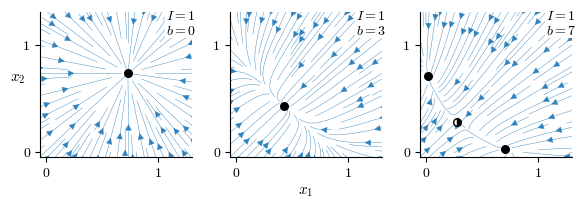

In [8]:
def F(X, I, B):
    # this is our gain function
    return 1/(1+np.exp(-(I-B*X)))

def plot_vector_field(ax, I, b):

        # lay down the grid
        X1 = np.arange(-0.2, 1.8, 0.2)
        X2 = np.arange(-0.2, 1.8, 0.2)
        X1, X2 = np.meshgrid(X1, X2)

        # vector field equations
        U1 = -X1 + F(X2, I, b)
        U2 = -X2 + F(X1, I, b)

        fixed_point_size=30
        # visualize vector field
        #     ax.quiver(X1, X2, U1, U2,color=[0.85, 0.37, 0.05]);
        ax.streamplot(X1, X2, U1, U2,
                      color=[0.19, 0.51, 0.74],
                      linewidth=.3,density=(1.5,1),minlength=0.1)

        ax.text(1.2, 1.2, u'$I  = $'+str(I)+'\n'+u'$b = $'+str(b),
                bbox={'facecolor': 'white', 'alpha': 1, 'pad': 0.5, 'edgecolor': 'none'},
                horizontalalignment='center', verticalalignment='center',
                fontsize=10)

        # plot fixed points
        x = np.arange(0, 3, 0.001)
        f = x
        g = F(F(x, I, b), I, b)

        idx = np.argwhere(np.diff(np.sign(f - g))).flatten()
        if len(idx) == 3:

                ax.scatter(x[idx[1]],g[idx[1]],fixed_point_size, 'k', marker=MarkerStyle("o", fillstyle="right"), zorder=2)
                ax.scatter(x[idx[1]],g[idx[1]],fixed_point_size, 'w', edgecolor="k", marker=MarkerStyle("o", fillstyle="left"), zorder=2)

                ax.scatter(x[idx[0]], g[idx[2]],fixed_point_size, edgecolor='k', facecolor='black',zorder=2)

                ax.scatter(x[idx[2]], g[idx[0]],fixed_point_size, edgecolor='k', facecolor='black',zorder=2)

        else:
                ax.scatter(x[idx], g[idx], fixed_point_size, edgecolor='k', facecolor='black',zorder=2)
        return ax

# plot
fig = plt.figure(figsize=(6,2.2))
ax0 = fig.add_subplot(1,3,1)
plot_vector_field(ax0, 1, 0)
ax1 = fig.add_subplot(1,3,2)
plot_vector_field(ax1, 1, 3)
ax2 = fig.add_subplot(1,3,3)
plot_vector_field(ax2, 1, 7)

ax1.set_xlabel('$x_1$',fontsize=11)
ax0.set_ylabel('$x_2$',fontsize=11,rotation=0)


for ax in [ax0, ax1, ax2]:
        ax.set_xlim((-0.05,1.3))
        ax.set_ylim((-0.05,1.3))
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.set_xticks([0,1])
        ax.set_yticks([0,1])
        ax.set_xticklabels([0,1],fontsize=10)
        ax.set_yticklabels([0,1],fontsize=10)

fig.tight_layout()

if Save:
        fig.savefig(str(savedir / 'binocular-rivalry.pdf'), dpi=600, format='pdf', bbox_inches='tight')

<ipython-input-9-b26f2649dd01>:35: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  root = fsolve(diff_func, guess)


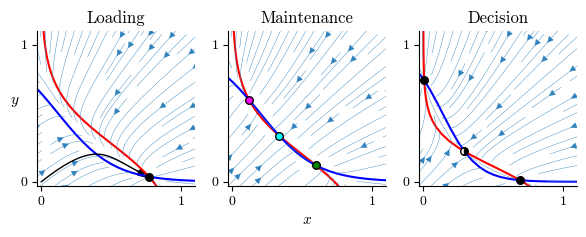

In [9]:
from scipy.optimize import fsolve
from scipy.integrate import odeint

def F(X, I, B, c):
    # this is our gain function
    return 1/(1+np.exp(-(I-B*X+c)))

def plot_vector_field(ax, I, b, c1, c2):

    # lay down the grid
    X1 = np.arange(-0.2, 1.8, 0.05)
    X2 = np.arange(-0.2, 1.8, 0.05)
    X1, X2 = np.meshgrid(X1, X2)

    # vector field equations
    U1 = -X1 + F(X2, I, b, c1,)
    U2 = -X2 + F(X1, I, b, c2,)
    ax.contour(X1, X2, U1, levels=[0], colors='r')  # x-nullcline
    ax.contour(X1, X2, U2, levels=[0], colors='b')  # y-nullcline

    fixed_point_size=30
    # visualize vector field
    #     ax.quiver(X1, X2, U1, U2,color=[0.85, 0.37, 0.05]);
    ax.streamplot(X1, X2, U1, U2,
                    color=[0.19, 0.51, 0.74],
                    linewidth=.3,density=(1.5,1),minlength=0.1)

    def diff_func(vars):
        X1, X2 = vars
        return [-X1 + F(X2, I, b, c1,), -X2 + F(X1, I, b, c2,)]

    # Find intersection points numerically
    intersection_points = []
    for guess in [(0, 1), (0.2, 0.2), (1, 0)]:
        root = fsolve(diff_func, guess)
        if not any(np.all(np.isclose(root, existing_point, atol=1e-5)) for existing_point in intersection_points):
            intersection_points.append(root)

    return intersection_points

# plot
fig, (ax0, ax1, ax2)= plt.subplots(1, 3, figsize=(6,2.5))
intersection_points = plot_vector_field(ax0, I=1, b=5, c1=0.4, c2=-0.4)
ax0.scatter(intersection_points[1][0], intersection_points[1][1], 30, edgecolor='k', facecolor='black',zorder=2)
ax0.set_title("Loading", fontsize=12)

# Define the system of differential equations
def system(vars, t, I, b, c1, c2):
    X1, X2 = vars
    U1 = -X1 + F(X2, I, b, c1,)
    U2 = -X2 + F(X1, I, b, c2,)
    return [U1, U2]

# Coefficients
I, b, c1, c2 = 1, 5, 0.4, -0.4

# Time points to solve the system
t = np.linspace(0, 5, 100)

# Initial conditions
x0, y0 = 0, 0  # Starting point

# Solve the system
trajectory = odeint(system, [x0, y0], t, args=(I, b, c1, c2))

ax0.plot(trajectory[:, 0], trajectory[:, 1], 'k', linewidth=1)
# Arrow properties
start_idx = -20  # Index to start the arrow (from the end of the trajectory)
end_idx = -13    # Index to end the arrow (last point of the trajectory)

# Calculate the arrow properties
dx = trajectory[end_idx, 0] - trajectory[start_idx, 0]
dy = trajectory[end_idx, 1] - trajectory[start_idx, 1]
arrow_start_x = trajectory[start_idx, 0]
arrow_start_y = trajectory[start_idx, 1]

# Add the arrow to the plot
ax0.arrow(arrow_start_x, arrow_start_y, dx, dy, head_width=0.05, head_length=0.1, fc='k', ec='k')

intersection_points = plot_vector_field(ax1, I=1, b=5, c1=0, c2=0)
ax1.scatter(intersection_points[0][0], intersection_points[0][1], 30, edgecolor='k', facecolor='magenta',zorder=2)
ax1.scatter(intersection_points[1][0], intersection_points[1][1], 30, edgecolor='k', facecolor='cyan',zorder=2)
ax1.scatter(intersection_points[2][0], intersection_points[2][1], 30, edgecolor='k', facecolor='green',zorder=2)
ax1.set_title("Maintenance", fontsize=12)

intersection_points= plot_vector_field(ax2, I=1, b=8, c1=-0.1, c2=0.1)
ax2.scatter(intersection_points[0][0], intersection_points[0][1], 30, edgecolor='k', facecolor='black',zorder=2)
ax2.scatter(intersection_points[1][0], intersection_points[1][1], 30, 'k', marker=MarkerStyle("o", fillstyle="right"), zorder=2)
ax2.scatter(intersection_points[1][0], intersection_points[1][1], 30, 'w', edgecolor="k", marker=MarkerStyle("o", fillstyle="left"), zorder=2)
ax2.scatter(intersection_points[2][0], intersection_points[2][1], 30, edgecolor='k', facecolor='black',zorder=2)
ax2.set_title("Decision", fontsize=12)

ax1.set_xlabel('$x$',fontsize=11)
ax0.set_ylabel('$y$',fontsize=11,rotation=0)

for ax in [ax0, ax1, ax2]:
    ax.set_xlim((-0.03,1.1))
    ax.set_ylim((-0.03,1.1))
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xticks([0,1])
    ax.set_yticks([0,1])
    ax.set_xticklabels([0,1],fontsize=10)
    ax.set_yticklabels([0,1],fontsize=10)

fig.tight_layout()
if Save:
    fig.savefig(str(savedir / 'Machens-nullclines.pdf'), bbox_inches='tight')
    fig.savefig(str(savedir / 'Machens-nullclines.svg'), bbox_inches='tight')

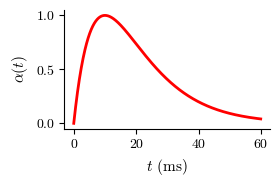

In [10]:
def a(t, Pmax, ts):
    return Pmax/ts * t * np.exp(1-t/ts)

t = np.arange(0,60,0.1)
Pmax = 1
ts = 10
fig, ax = plt.subplots(figsize=(3,2))
plot(t, a(t, Pmax, ts), axes=ax)
ax.set_xlabel(r'$t$ (ms)')
ax.set_ylabel(r'$\alpha(t)$')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
fig.tight_layout()

if Save:
    fig.savefig(str(savedir / 'alpha-function.pdf'), dpi=600, format='pdf', bbox_inches='tight');

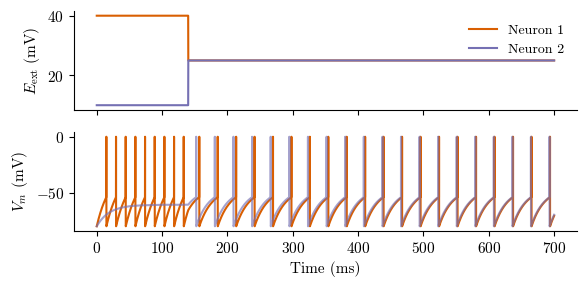

In [11]:
# parameters
dt = 0.1 # time resolution of simulation (ms)
T = 700 # total time to simulate (ms)

ES = -80 # synaptic reversal potential (mV)
EL = -70 # leakage potential (mV)
Vth = -54 # threshold potential (mV)
Vreset = -80 # reset potential after firing (mV)
Eext = 25 # external input (mV)
tm = 20 # membrane time constant (ms)
ts = 10 # synaptic time constant (ms)
k = 0.05 # synaptic conductance
Pmax = 1 # max synaptic transmission upon presynaptic firing

# arrays to hold results
timepoints = int(T/dt)
V1 = np.ones(timepoints)
V2 = np.ones(timepoints)

# initial condition
V1[0] = Vreset
V2[0] = Vreset

# input
V1_input = 40
V2_input = 10

# solve diff eq, this time 'manually'
for n in range(1,timepoints):

    # if threshold crossing, ap
    if V1[n-1] > Vth:
        V1[n-1] = 0
        V1[n] = Vreset

    else:
        # synaptic conductance follows alpha function
        spike_times = np.nonzero(V2==0)[0]
        if len(spike_times)==0:
            Ps1=0
        else:
            most_recent_spike_time = np.max(spike_times)
            Ps1 = (Pmax*(n-most_recent_spike_time)/(ts/dt)
              *np.exp(1-(n-most_recent_spike_time)/(ts/dt)))

        # update
        if n < timepoints/5:
            dV1 = (EL-V1[n-1]-k*Ps1*(V1[n-1]-ES)+V1_input) / (tm/dt)
        else:
            dV1 = (EL-V1[n-1]-k*Ps1*(V1[n-1]-ES)+Eext) / (tm/dt)
        V1[n] = V1[n-1] + dV1

    # same for second neuron
    if V2[n-1] > Vth:
        V2[n-1] = 0
        V2[n] = Vreset

    else:
        spike_times = np.nonzero(V1==0)[0]
        if len(spike_times)==0:
            Ps2=0
        else:
            most_recent_spike_time = np.max(spike_times)
            Ps2 = (Pmax*(n-most_recent_spike_time)/(ts/dt)
              *np.exp(1-(n-most_recent_spike_time)/(ts/dt)))

        if n < timepoints/5:
            dV2 = (EL-V2[n-1]-k*Ps2*(V2[n-1]-ES)+V2_input) / (tm/dt)
        else:
            dV2 = (EL-V2[n-1]-k*Ps2*(V2[n-1]-ES)+Eext) / (tm/dt)

        V2[n] = V2[n-1] + dV2

# plot results
color1 = np.array([217,95,2])/255
color2 = np.array([117,112,179])/255
time = np.linspace(0, T, timepoints)
fig,ax = plt.subplots(2,1,figsize=(6,3),sharex=True, height_ratios=[1,1])
ax[0].plot(time, np.concatenate((V1_input*np.ones(len(time[:int(timepoints/5)])), Eext*np.ones(len(time[int(timepoints/5):])))), color=color1, label='Neuron 1');
ax[0].plot(time, np.concatenate((V2_input*np.ones(len(time[:int(timepoints/5)])), Eext*np.ones(len(time[int(timepoints/5):])))), color=color2, label='Neuron 2');
ax[0].set_ylabel('$E_{\mathrm{ext}}$ (mV)');
ax[1].plot(time, V1, color=color1, label='Neuron 1');
ax[1].plot(time, V2, color=color2, alpha=0.65, label='Neuron 2');
ax[1].set_xlabel('Time (ms)');
ax[1].set_ylabel('$V_m$ (mV)');
ax[0].legend(loc='upper right', frameon=False, fontsize=10)
fig.tight_layout()
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)

if Save:
    fig.savefig(str(savedir / 'sync-mutual-inhibition.pdf'), dpi=600, format='pdf', bbox_inches='tight');

## Turing patterns

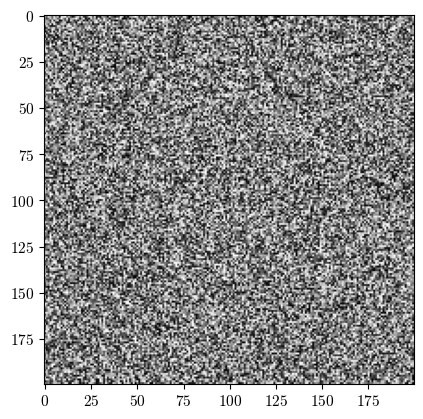

In [12]:
from scipy.ndimage import laplace
from numpy.random import default_rng
from scipy.integrate import solve_ivp
import numpy as np

rg = default_rng(474)

# square grid of 200x200
grid_size = [200, 200]

# initial condition
u0 = np.random.random_sample(size=grid_size)
v0 = np.random.random_sample(size=grid_size)

y0 = np.concatenate((np.reshape(u0,-1), np.reshape(v0,-1)))
plt.imshow(np.reshape(y0[grid_size[0]*grid_size[1]:],grid_size),cmap='gray')

# parameters
D = 0.45
delta = 6.0
alpha = 0.899
beta = -0.91
gamma = -alpha
r_2 = 2.0
r_3 = 3.5

# model for the dynamical system
def rd(t, y, D, delta, alpha, beta, gamma, r_2, r_3):
    """
    reaction-diffusion equations
    """
    # unpack and reshape to 2d
    u = np.reshape(y[:grid_size[0]*grid_size[1]],grid_size)
    v = np.reshape(y[grid_size[0]*grid_size[1]:],grid_size)

    # diff eqs
    u_dot = D*delta*laplace(u, mode='reflect') + alpha*u + v -r_2*u*v - alpha*r_3*u*(v**2)
    v_dot = delta*laplace(v, mode='reflect') + gamma*u + beta*v + r_2*u*v + alpha*r_3*u*(v**2)

    # zero flux boundary conditions
    # u_dot[0,:] = u_dot[-1,:] = u_dot[:,0] = u_dot[:,-1] = 0
    # v_dot[0,:] = v_dot[-1,:] = v_dot[:,0] = v_dot[:,-1] = 0

    return np.concatenate((np.reshape(u_dot,-1), np.reshape(v_dot,-1)))


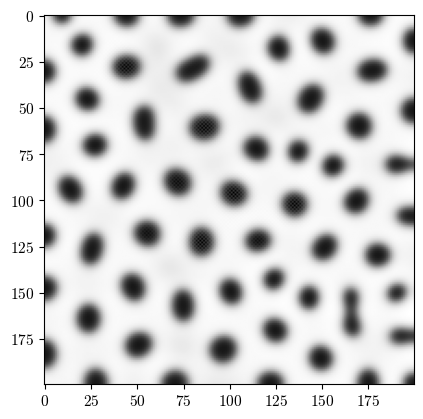

In [13]:

# solve and visualize (may take a while...)
first_stage = solve_ivp(rd, (0,160), y0, method = 'RK23', args=(D,delta,alpha,beta,gamma,r_2,r_3), t_eval=np.arange(0, 160, 10),
                        rtol=1e-2, atol=1e-4)
spots = first_stage.y[:,first_stage.t==150].flatten()
plt.imshow(np.reshape(spots[grid_size[0]*grid_size[1]:],grid_size),cmap='gray')
# np.save(datadir / 'TuringPatterns_spots.npy', spots)

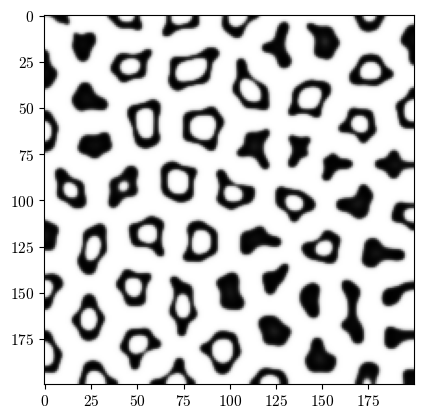

In [14]:

second_stage = solve_ivp(rd, (0,20), spots, method = 'RK23', args=(D,delta,alpha,beta,gamma,9.0,r_3), t_eval=np.arange(0,20,0.2))
rings = second_stage.y[:,second_stage.t==14.8].flatten()
plt.imshow(np.reshape(rings[grid_size[0]*grid_size[1]:],grid_size),cmap='gray')
# np.save(datadir / 'TuringPatterns_rings.npy', rings)

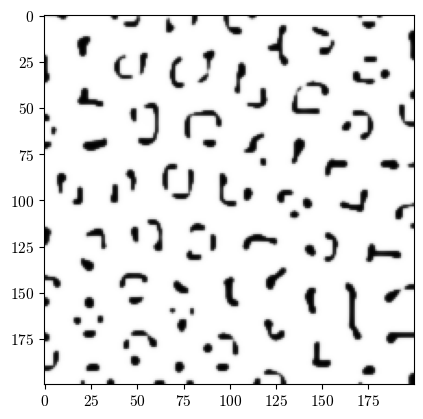

In [15]:

third_stage = solve_ivp(rd, (0,11), rings, method = 'RK23', args=(D,3.8,alpha,beta,gamma,9.0,r_3), t_eval=np.arange(0,11,0.5))
rosettes = third_stage.y[:,third_stage.t==10.5].flatten()
plt.imshow(np.reshape(rosettes[grid_size[0]*grid_size[1]:],grid_size),cmap='gray')
# np.save(datadir / 'TuringPatterns_rosettes.npy', rosettes)

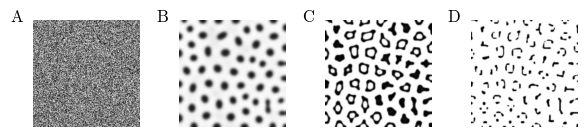

In [16]:
# spots = np.load(datadir / 'TuringPatterns_spots.npy')
# rings = np.load(datadir / 'TuringPatterns_rings.npy')
# rosettes = np.load(datadir / 'TuringPatterns_rosettes.npy')

fig, ax = plt.subplots(1,4, figsize=(6,2.5))
ax[0].imshow(np.reshape(y0[grid_size[0]*grid_size[1]:],grid_size),cmap='gray')
ax[1].imshow(np.reshape(spots[grid_size[0]*grid_size[1]:],grid_size),cmap='gray')
ax[2].imshow(np.reshape(rings[grid_size[0]*grid_size[1]:],grid_size),cmap='gray')
ax[3].imshow(np.reshape(rosettes[grid_size[0]*grid_size[1]:],grid_size),cmap='gray')
ax[0].axis('off')
ax[1].axis('off')
ax[2].axis('off')
ax[3].axis('off')
labels = ['A', 'B', 'C', 'D']
for i, ax_row in enumerate(ax):
    ax_row.text(-0.1, 1.1, labels[i], transform=ax_row.transAxes,
                fontsize=12, fontweight='bold', va='top', ha='right')


fig.tight_layout()

if Save:
    fig.savefig(str(savedir / 'TuringPatterns.pdf'), bbox_inches='tight');
    fig.savefig(str(savedir / 'TuringPatterns.svg'), bbox_inches='tight');

## Circadian rhythms

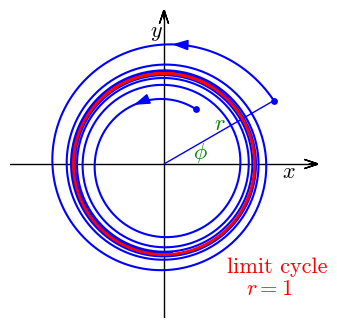

In [17]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(4,4))


axes.plot([-1.7,1.7],[0,0],color='k',linewidth=1)
axes.plot([0,0],[-1.7,1.7],color='k',linewidth=1)

L=1

Npoints=1200
dt=0.003

t=np.linspace(0,Npoints*dt,Npoints)
R=np.zeros(t.shape)
Phi=np.zeros(t.shape)
X=np.zeros(t.shape)
Y=np.zeros(t.shape)

R[0]=1.4
Phi[0]=30*2*np.pi/360
X[0]=R[0]*np.cos(Phi[0])
Y[0]=R[0]*np.sin(Phi[0])

axes.scatter(X[0],Y[0],15,'b')

for i in range(Npoints-1):

    R[i+1]=R[i]+dt*L*R[i]*(1-R[i])
    Phi[i+1]=Phi[i]+dt*2*np.pi
    X[i+1]=R[i+1]*np.cos(Phi[i+1])
    Y[i+1]=R[i+1]*np.sin(Phi[i+1])

axes.plot(X,Y,color='b',linewidth=1.5)
axes.plot([0,X[0]],[0,Y[0]],color='b',linewidth=1)
t=50
axes.arrow(X[t],Y[t],X[t+1]-X[t],Y[t+1]-Y[t],width=0.001,length_includes_head=True,head_width=0.1,color='b')


R[0]=0.7
Phi[0]=60*2*np.pi/360
X[0]=R[0]*np.cos(Phi[0])
Y[0]=R[0]*np.sin(Phi[0])
axes.scatter(X[0],Y[0],15,'b')



for i in range(Npoints-1):

    R[i+1]=R[i]+dt*L*R[i]*(1-R[i])
    Phi[i+1]=Phi[i]+dt*2*np.pi
    X[i+1]=R[i+1]*np.cos(Phi[i+1])
    Y[i+1]=R[i+1]*np.sin(Phi[i+1])

axes.plot(X,Y,color='b',linewidth=1.5)
t=50
axes.arrow(X[t],Y[t],X[t+1]-X[t],Y[t+1]-Y[t],width=0.001,length_includes_head=True,head_width=0.1,color='b')

Npoints=400

t=np.linspace(0,Npoints*dt,Npoints)
R=np.zeros(t.shape)
Phi=np.zeros(t.shape)
X=np.zeros(t.shape)
Y=np.zeros(t.shape)

R[0]=1
Phi[0]=60*2*np.pi/360
X[0]=R[0]*np.cos(Phi[0])
Y[0]=R[0]*np.sin(Phi[0])

for i in range(Npoints-1):

    R[i+1]=R[i]+dt*L*R[i]*(1-R[i])
    Phi[i+1]=Phi[i]+dt*2*np.pi
    X[i+1]=R[i+1]*np.cos(Phi[i+1])
    Y[i+1]=R[i+1]*np.sin(Phi[i+1])

axes.plot(X,Y,color='r',linewidth=2)
axes.text(0.7,-1.2,r'limit cycle',fontsize=16,color='r')
axes.text(0.9,-1.45,r'$r=1$',fontsize=16,color='r')
axes.text(1.3,-0.15,r'$x$',fontsize=16,color='k')
axes.text(-0.15,1.4,r'$y$',fontsize=16,color='k')
axes.text(0.55,0.38,r'$r$',fontsize=16,color='g')
axes.text(0.32,0.06,r'$\phi$',fontsize=16,color='g')



axes.set_xticks([-1,0,1],['-1','0','1'])
axes.set_yticks([-1,0,1],['-1','0','1'])

axes.set_xlim([-1.7,1.7])
axes.set_ylim([-1.7,1.7])
axes.arrow(0,1.6,0,0.1,width=0.001,length_includes_head=True,head_width=0.1,
                overhang=1,color='k')
axes.arrow(1.6,0,0.1,0,width=0.001,length_includes_head=True,head_width=0.1,
                overhang=1,color='k')

axes.axis('off')

axes.set_aspect('equal')

if Save:
    fig.savefig(str(savedir / 'cycle-oscillator1.pdf'), bbox_inches='tight')
    fig.savefig(str(savedir / 'cycle-oscillator1.svg'), bbox_inches='tight')

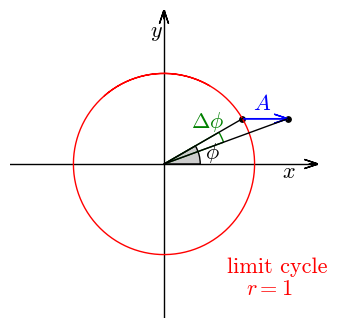

In [18]:
from matplotlib.patches import Wedge

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(4,4))

axes.plot([-1.7,1.7],[0,0],color='k',linewidth=1)
axes.plot([0,0],[-1.7,1.7],color='k',linewidth=1)

L=1
Npoints=400

t=np.linspace(0,Npoints*dt,Npoints)
R=np.zeros(t.shape)
Phi=np.zeros(t.shape)
X=np.zeros(t.shape)
Y=np.zeros(t.shape)


R[0]=1
Phi[0]=60*2*np.pi/360
X[0]=R[0]*np.cos(Phi[0])
Y[0]=R[0]*np.sin(Phi[0])

for i in range(Npoints-1):

    R[i+1]=R[i]+dt*L*R[i]*(1-R[i])
    Phi[i+1]=Phi[i]+dt*2*np.pi
    X[i+1]=R[i+1]*np.cos(Phi[i+1])
    Y[i+1]=R[i+1]*np.sin(Phi[i+1])

axes.plot(X,Y,color='r',linewidth=1)
axes.text(0.7,-1.2,r'limit cycle',fontsize=16,color='r')
axes.text(0.9,-1.45,r'$r=1$',fontsize=16,color='r')
axes.text(1.3,-0.15,r'$x$',fontsize=16,color='k')
axes.text(-0.15,1.4,r'$y$',fontsize=16,color='k')


R[0]=1
Phi[0]=30*2*np.pi/360
X[0]=R[0]*np.cos(Phi[0])
Y[0]=R[0]*np.sin(Phi[0])

axes.scatter(X[0],Y[0],15,'k')
axes.plot([0,X[0]],[0,Y[0]],color='k',linewidth=1)
axes.scatter(X[0]+0.5,Y[0],15,'k')
axes.plot([0,X[0]+0.5],[0,Y[0]],color='k',linewidth=1)
axes.arrow(X[0],Y[0],0.5,0,width=0.001,length_includes_head=True,head_width=0.1,
                overhang=1,color='b')
# axes.arrow(X[0],Y[0]+0.05,0.5,0,width=0.001,length_includes_head=True,head_width=0.1,
#                 overhang=1,color='b')

axes.add_patch(Wedge([0, 0], 0.4, 0, 180/np.pi*Phi[0], edgecolor='k',facecolor='0.8'))
axes.add_patch(Wedge([0, 0], 0.7, 180/np.pi*np.arctan(Y[0]/(X[0]+0.5)), 180/np.pi*Phi[0], edgecolor='g',facecolor='none'))

axes.text(X[0]+0.12,Y[0]+0.1,r'$A$',fontsize=16,color='b')


axes.set_xticks([-1,0,1],['-1','0','1'])
axes.set_yticks([-1,0,1],['-1','0','1'])

axes.set_xlim([-1.7,1.7])
axes.set_ylim([-1.7,1.7])
axes.arrow(0,1.6,0,0.1,width=0.001,length_includes_head=True,head_width=0.1,
                overhang=1,color='k')
axes.arrow(1.6,0,0.1,0,width=0.001,length_includes_head=True,head_width=0.1,
                overhang=1,color='k')

axes.text(0.3,0.4,r'$\Delta \phi$',fontsize=16,color='g')
axes.text(0.45,0.06,r'$\phi$',fontsize=16,color='k')

axes.axis('off')

axes.set_aspect('equal')

if Save:
    fig.savefig(str(savedir / 'cycle-oscillator2.pdf'),  bbox_inches='tight')
    fig.savefig(str(savedir / 'cycle-oscillator2.svg'),  bbox_inches='tight')

### Neuroscience

#### The integrate-and-fire model of a neuron

Equations and simulation

\begin{align*}
\tau \frac{dV}{dt} &= - V(t) + RI(t) + N(t) \\
I(t) &= \textrm{ injected current} \\
R &= \textrm{ membrane resistance} \\
N(t) &= \textrm{ noise voltage} \\
\textrm{When } V &= V_{\rm{t}} \textrm{ emit a spike and reset } V \textrm{ to } V_{\rm{r}}
\end{align*}


In [19]:
# Simulate voltage trace in one trial

tau = 0.015 # membrane time constant in s
noa = 5 # noise amplitude in mV
vth = 28 # voltage threshold in mV
vre = -10 # voltage reset in mV
ico = 30 # amplitude of constant input RI in mV

T = 1 # duration of a trial in s
dt = 0.001 # time resolution in s
np.random.seed(4) # random seed

t=np.arange(0,T,dt) # time during a trial in s
N=len(t) # number of data points in a trial
ir=np.zeros(N) # input current in mV

ir[:]=ico*(t>0.1) # constant input current starts at 0.1 s
no=np.random.normal(0,noa,size=N) # gaussian noise
v=np.zeros(N) # membrane potential in mV
v[0]=0 # start at zero potential
st=[] # spike times
for i in range(1,N):
    v[i]=v[i-1]+(ir[i-1]+no[i-1]-v[i-1])*dt/tau # dynamics
    if v[i]>vth: # check for threshold
        st+=[t[i]] # emit a spike
        v[i]=vre # reset potential

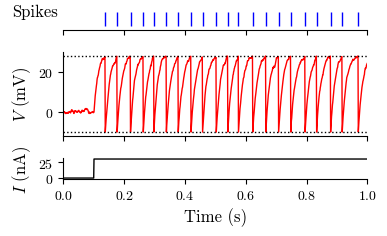

In [20]:
from matplotlib.gridspec import GridSpec
fig,ax=plt.subplots(3,1,figsize=(4,2.5),gridspec_kw={'height_ratios':[1,4,1]},
                   sharex=True)
plot(st,np.zeros(len(st)),axes=ax[0],
     # ylabel='Spikes',
     fmts=['b|'],markersize=10,linewidth=1);
plot(t,v,
     # ylabel='Voltage (mV)',
     axes=ax[1],linewidth=1);
plot([0,T],[[vre,vre],[vth,vth]],fmts=['k:','k:'],
     # ylabel='Voltage (mV)',
     axes=ax[1],linewidth=1);
plot(t,ir,axes=ax[2],
     # xlabel='Time (s)',ylabel='Current',
     fmts=['k-'],linewidth=1,
     xlim=[0,1]);
ax[0].spines.left.set_visible(False)
ax[0].spines.top.set_visible(False)
ax[0].spines.right.set_visible(False)
ax[0].get_yaxis().set_ticks([]);
ax[0].set_ylabel('Spikes', rotation=0, fontdict={'fontsize':12}, labelpad=20)
ax[1].spines.right.set_visible(False)
ax[1].spines.top.set_visible(False)
ax[1].set_ylabel(r'$V$ (mV)', fontdict={'fontsize':12})
ax[2].spines.right.set_visible(False)
ax[2].spines.top.set_visible(False)
ax[2].set_ylabel(r'$I$ (nA)', fontdict={'fontsize':12})
ax[2].set_xlabel('Time (s)', fontdict={'fontsize':12})
ax[2].set_xticks(np.arange(0,1.2,.2))
# ax[2].set_xticklabels(['0'] + 4*[''] + ['1'])
fig.tight_layout()

if Save:
     fig.savefig(str(savedir / 'IF_Model_Trace.pdf'), bbox_inches='tight')
     fig.savefig(str(savedir / 'IF_Model_Trace.svg'), bbox_inches='tight')

#### What is the mechanism of the action potential?

Hodgkin-Huxley model: with inspiration from a problem set by Vijay Balasubramanian, which in turn relies on Dayan & Abbott 2005, Ch 5.5.

Dynamics of a single-compartment model

Dimensions: If we measure $c_m$ in $\mathrm{\mu F} / \mathrm{mm}^2$, $V$ in $\mathrm{mV}$, $t$ in $\mathrm{ms}$, $A$ in $\mathrm{mm}^2$, then $i_m$ is in $\mathrm{\mu A} / \mathrm{mm}^2$ and $I_e$ in $\mathrm{\mu A}$.

In [21]:
c_m = 0.01 # in uF/mm^2
A = 0.1 # in mm^2 # isn't that huge? for squid axon perhaps OK

Membrane current of the Hodgkin-Huxley model

With the g's and E's expressed in these units, the membrane current is in units of $\mu$A/mm$^2$.

In [22]:
g_L=0.003 # in mS/mm^2
g_K=0.36
g_Na=1.2
E_L=-54.387 # in mV # why so precise?
E_K=-77
E_Na=50

In [23]:
def i_m(V,n,m,h):
    return g_L*(V-E_L)+g_K*n**4*(V-E_K)+g_Na*m**3*h*(V-E_Na)

#### Activation and de-inactivation probabilities
$n(t)$, $m(t)$ and $h(t)$ follow the same equation (here shown for $n(t)$):

#### Opening and closing rate functions
These expressions assume that $V$ is measured in mV, and time is measured in ms, i.e. the units of $\alpha$ and $\beta$ are ms$^{-1}$.

In [24]:
def al_n(V):
    return 0.01*(V+55)/(1-np.exp(-0.1*(V+55)))

def al_m(V):
    return 0.1*(V+40)/(1-np.exp(-0.1*(V+40)))

def al_h(V):
    return 0.07*np.exp(-0.05*(V+65))

def be_n(V):
    return 0.125*np.exp(-0.0125*(V+65))

def be_m(V):
    return 4*np.exp(-0.0556*(V+65))

def be_h(V):
    return 1/(1+np.exp(-0.1*(V+35)))

#### Time constants
$\tau_n(V)$,  $\tau_m(V)$, and $\tau_h(V)$ follow the same dependence (here shown for $\tau_n(V)$):

Again, the numerical values of the $\alpha$ and $\beta$ are such that $\tau$ is measured in ms.

In [25]:
# time constants
def t_n(V):
    return 1/(al_n(V)+be_n(V))

def t_m(V):
    return 1/(al_m(V)+be_m(V))

def t_h(V):
    return 1/(al_h(V)+be_h(V))

#### Steady-state activation and de-inactivation rates
$n_\infty$, $m_\infty$, and $h_\infty$ follow the same equation (here shown for
$n_\infty$):

In [26]:
# steady state rates n, m, h
def n_inf(V):
    return al_n(V)/(al_n(V)+be_n(V))

def m_inf(V):
    return al_m(V)/(al_m(V)+be_m(V))

def h_inf(V):
    return al_h(V)/(al_h(V)+be_h(V))

#### Some voltage-dependencies

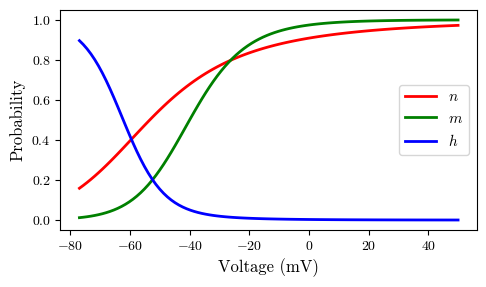

In [27]:
# steady state probabilities
V=np.linspace(E_K,E_Na,100) # full voltage range in mV
plot(V,[n_inf(V),m_inf(V),h_inf(V)],legend=['$n$','$m$','$h$'],
    xlabel='Voltage (mV)',ylabel='Probability');

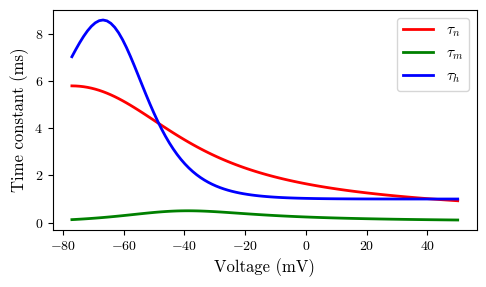

In [28]:
# time constants
plot(V,[t_n(V),t_m(V),t_h(V)],legend=[r'$\tau_n$',r'$\tau_m$',r'$\tau_h$'],
    xlabel='Voltage (mV)',ylabel='Time constant (ms)');

#### Simulation

In [29]:
# response to current step
def sim_HH(I):
    '''
    Simulates voltage response of the HH model to a current step I (in uA)
    Returns:
    t=time series in ms
    v=voltage series in mV
    '''
    # initial conditions
    V_0=-65 # resting potential in mV
    V=V_0
    n=n_inf(V)
    m=m_inf(V)
    h=h_inf(V)

    # time scale
    T=100 # duration in ms
    dt=0.01 # time step in ms
    t=np.linspace(0,T,int(T/dt)) # time axis in ms

    # input current
    I_e=np.zeros(len(t)) # current measured in uA
    I_e+=I*(t>20) # start injecting current at 20 ms

    Vs=[]
    j=0
    while j<len(t):
        n+=dt*(al_n(V)*(1-n)-be_n(V)*n)
        m+=dt*(al_m(V)*(1-m)-be_m(V)*m)
        h+=dt*(al_h(V)*(1-h)-be_h(V)*h)
        V+=dt/c_m*(I_e[j]/A-i_m(V,n,m,h))
        Vs+=[V]
        j+=1

    return t,np.array(Vs)

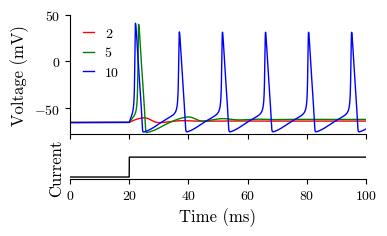

In [30]:
from matplotlib.gridspec import GridSpec
Is=[0.002,0.005,0.01]
t,v=sim_HH(Is[0])
vs=[v]+[sim_HH(I)[1] for I in Is[1:]]
fig,ax=plt.subplots(2,1,figsize=(4,2.5),gridspec_kw={'height_ratios':[5,1]},
                   sharex=True)
plot(t,vs,ylim=[E_K,E_Na],
    #  legend=list(1000*np.array(Is)), # current in nA
    ylabel='Voltage (mV)',axes=ax[0],linewidth=1);
I=1.0*(t>20)
plot(t,I,axes=ax[1],xlabel='Time (ms)',ylabel='Current',fmts=['k-'],linewidth=1,
     ylim=[-0.1,1.1],xlim=[0,100]);
ax[1].get_yaxis().set_ticks([]);
ax[1].spines.right.set_visible(False)
ax[1].spines.left.set_visible(False)
ax[1].spines.top.set_visible(False)
ax[0].spines.right.set_visible(False)
ax[0].spines.top.set_visible(False)
ax[0].legend(['2','5','10'], frameon=False, fontsize=10, loc='upper left', handlelength=0.8)
fig.tight_layout()

if Save:
    fig.savefig(str(savedir / 'HH_Model_Spikes.pdf'), bbox_inches='tight')
    fig.savefig(str(savedir / 'HH_Model_Spikes.svg'), bbox_inches='tight')

In [31]:
# response to voltage step
def sim_HH_V(dV):
    '''
    Simulates response of the HH model to a voltage step dV (in mV)
    Returns:
    t=time series in ms
    v=voltage series in mV
    [n,m,h]=series of the gating variables
    '''
    # time scale
    T=100 # duration in ms
    dt=0.01 # time step in ms
    t=np.linspace(0,T,int(T/dt)) # time axis in ms

    # inputs
    V_0=-65 # resting potential in mV
    V=np.full(len(t),V_0) # voltage in mV
    V+=dV*(t>20) # start voltage step at 20 ms
    I_e=0 # no injected current

    # initial conditions
    n=n_inf(V_0)
    m=m_inf(V_0)
    h=h_inf(V_0)
    j=0
    Ns=[];Ms=[];Hs=[]
    while j<len(t):
        n+=dt*(al_n(V[j])*(1-n)-be_n(V[j])*n)
        m+=dt*(al_m(V[j])*(1-m)-be_m(V[j])*m)
        h+=dt*(al_h(V[j])*(1-h)-be_h(V[j])*h)
        Ns+=[n];Ms+=[m];Hs+=[h]
        j+=1

    return t,V,np.array([Ns,Ms,Hs])

In [32]:
t,V,Ps=sim_HH_V(40)

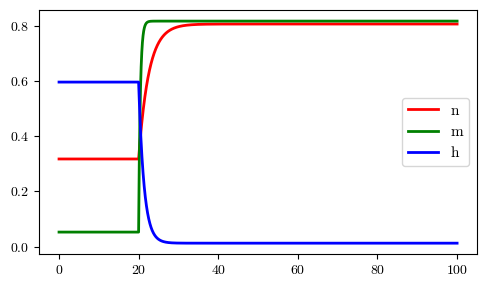

In [33]:
plot(t,Ps,legend=['n','m','h']);

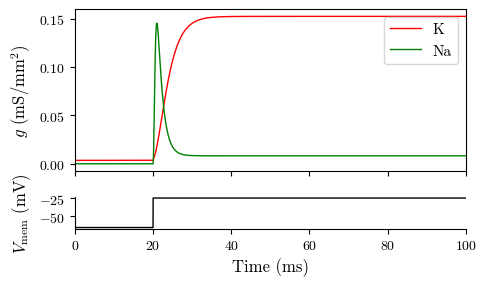

In [34]:
from matplotlib.gridspec import GridSpec
fig,ax=plt.subplots(2,1,figsize=(5,3),gridspec_kw={'height_ratios':[5,1]},
                   sharex=True)
plot(t,[g_K*Ps[0]**4,g_Na*Ps[1]**3*Ps[2]],legend=['K','Na'],
    ylabel='$g$ (mS/mm$^2$)',axes=ax[0],linewidth=1);
plot(t,V,axes=ax[1],xlabel='Time (ms)',ylabel='$V_\mathrm{mem}$ (mV)',fmts=['k-'],linewidth=1,
     xlim=[0,100]);
ax[1].spines.right.set_visible(False)
ax[1].spines.top.set_visible(False)
fig.tight_layout()

if Save:
    fig.savefig(str(savedir / 'HH_Model_V_clamp.pdf'), dpi=600, format='pdf', bbox_inches='tight');